In [33]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
import matplotlib.dates as mdates

In [34]:
def load_market_data(asset, date_from, date_to):
    print(f"Fetching dataset for {asset}...")

    df = yf.download(asset, start=date_from, end=date_to)

    # Handle MultiIndex issues
    if isinstance(df.columns, pd.MultiIndex):
        df = df.xs(asset, axis=1, level=1) if asset in df.columns.levels[1] else df

    # Price selection
    price_key = 'Adj Close' if 'Adj Close' in df.columns else 'Close'
    df = df[[price_key]].copy()
    df.rename(columns={price_key: 'Price'}, inplace=True)

    # Compute Log Returns
    df['LogReturn'] = np.log(df['Price'] / df['Price'].shift(1))
    df.dropna(inplace=True)

    return df


In [35]:
def build_hmm_model(return_data, state_count=3):
    print(f"Training Gaussian HMM with {state_count} regimes...")

    sequence = return_data.values.reshape(-1, 1)

    hmm_model = GaussianHMM(
        n_components=state_count,
        covariance_type="full",
        n_iter=1000,
        random_state=42
    )

    hmm_model.fit(sequence)

    latent_states = hmm_model.predict(sequence)

    return hmm_model, latent_states


In [36]:
def summarize_states(hmm_model, state_total):
    print("\n--- Regime Summary ---")

    for sid in range(state_total):
        print(f"State {sid}")
        print(f"  Mean Return: {hmm_model.means_[sid][0]:.6f}")
        print(f"  Variance:    {np.diag(hmm_model.covars_[sid])[0]:.6f}")
        print("-" * 30)

    print("\nState Transition Matrix:")
    print(hmm_model.transmat_)


In [37]:
def visualize_regimes(series_df, regime_labels, asset_name):

    plot_df = series_df.copy()
    plot_df['Regime'] = regime_labels

    colors = ['green', 'red', 'blue', 'orange']

    # --- Plot 1: Returns by Regime ---
    plt.figure(figsize=(14,6))

    for rid in range(hmm_model.n_components):
        sub = plot_df[plot_df['Regime'] == rid]
        plt.scatter(sub.index, sub['LogReturn'], s=10, alpha=0.6, label=f"Regime {rid}")

    plt.title(f"{asset_name} Log Returns Classified by Regime")
    plt.ylabel("Log Return")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    # --- Plot 2: Price by Regime ---
    plt.figure(figsize=(14,6))
    plt.plot(plot_df.index, plot_df['Price'], alpha=0.3, c='grey', label="Price")

    for rid in range(hmm_model.n_components):
        mask = (plot_df['Regime'] == rid)
        plt.scatter(plot_df.index[mask], plot_df['Price'][mask], s=5, label=f"Regime {rid}")

    plt.title(f"{asset_name} Price Segmented by Regimes")
    plt.ylabel("Price")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


/tmp/ipython-input-793322228.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(asset, start=date_from, end=date_to)
[*********************100%***********************]  1 of 1 completed


Fetching dataset for SPY...
Training Gaussian HMM with 3 regimes...

--- Regime Summary ---
State 0
  Mean Return: 0.001168
  Variance:    0.000050
------------------------------
State 1
  Mean Return: 0.000688
  Variance:    0.000055
------------------------------
State 2
  Mean Return: -0.001394
  Variance:    0.000291
------------------------------

State Transition Matrix:
[[1.39344709e-03 9.98588847e-01 1.77060491e-05]
 [9.72581252e-01 9.21905116e-03 1.81996969e-02]
 [3.03042259e-02 9.72375122e-03 9.59972023e-01]]

Interpretation Guide:
State w/ highest variance  → volatile / crash
State w/ positive mean     → bull market
State w/ low mean + low variance → stagnation


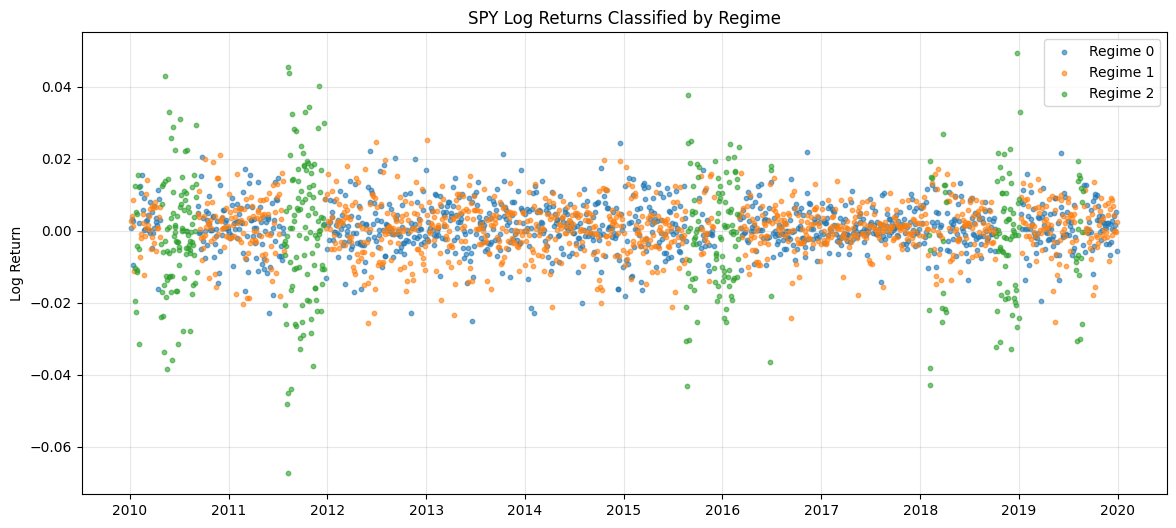

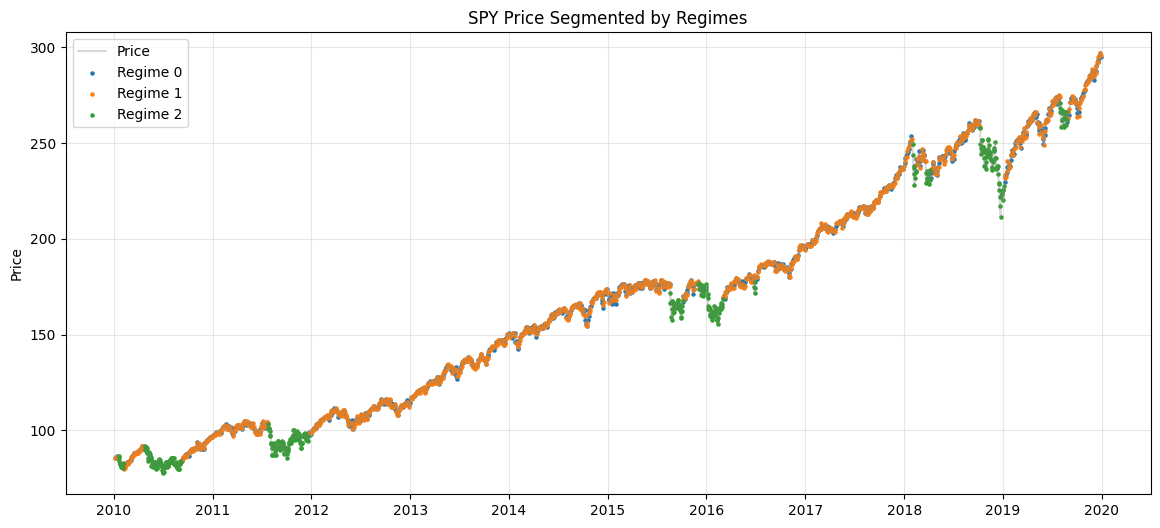

In [38]:
if __name__ == "__main__":

    ASSET = "SPY"
    DATE_FROM = "2010-01-01"
    DATE_TO = "2020-01-01"
    STATE_COUNT = 3

    # Step 1 : Data
    price_df = load_market_data(ASSET, DATE_FROM, DATE_TO)

    # Step 2 : Fit Model
    hmm_model, regime_seq = build_hmm_model(price_df['LogReturn'], state_count=STATE_COUNT)

    # Step 3 : Stats
    summarize_states(hmm_model, STATE_COUNT)

    print("\nInterpretation Guide:")
    print("State w/ highest variance  → volatile / crash")
    print("State w/ positive mean     → bull market")
    print("State w/ low mean + low variance → stagnation")

    # Step 4 : Plots
    visualize_regimes(price_df, regime_seq, ASSET)
